Diamonds Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mutual_info_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('data/diamonds.csv')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [3]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [4]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [5]:
categorical = ['cut', 'color', 'clarity'] 

# get numericals 
numerical = list(df.dtypes[df.dtypes != 'object'].index)
# we don't need price in numerical coloumns because it will be the target, so:
numerical.remove('price')
print('categorical: ', categorical)
print('numerical: ', numerical)

categorical:  ['cut', 'color', 'clarity']
numerical:  ['carat', 'depth', 'table', 'x', 'y', 'z']


## EDA

In [6]:
# find mising value
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

there are no missing values in dataset so let's take a look at numerical colymns including the target variable (price)

In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Let's take a look at categorical columns

In [8]:
# Find unique value in categorical
for c in categorical:
    print()
    print('------------%s----------'%c)
    print('Unique value: ', df[c].unique())
    print('Total of unique value: ', df[c].nunique())


------------cut----------
Unique value:  ['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
Total of unique value:  5

------------color----------
Unique value:  ['E' 'I' 'J' 'H' 'F' 'G' 'D']
Total of unique value:  7

------------clarity----------
Unique value:  ['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
Total of unique value:  8


and now, let's take a look at price column that become the target. 

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

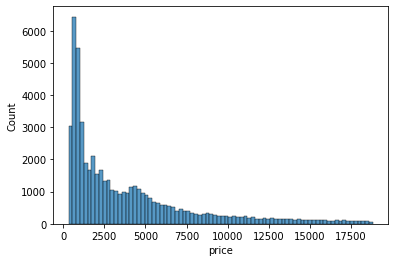

In [9]:
sns.histplot(df.price)

it has long tail. So, will use log1p

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='price', ylabel='Count'>

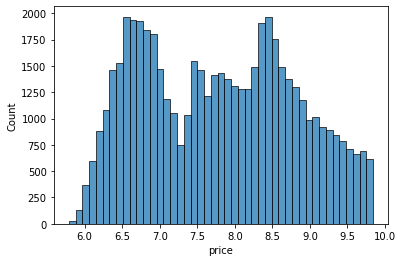

In [10]:
price_logs = np.log1p(df.price)
sns.histplot(price_logs)

the tail now is gone.

### Feature Importance

In [11]:
# find correlation between price with other numerical columns
for n in numerical:
    print(n, round(df[n].corr(df['price']), 3))

carat 0.922
depth -0.011
table 0.127
x 0.884
y 0.865
z 0.861


we can see that the ones who has big correlation with price are carat, x, y, z. and now search mutual information in categorical

In [12]:
for c in categorical:
    print(c, round(mutual_info_score(df[c], df['price']), 3))

cut 0.484
color 0.849
clarity 0.884


clarity and color have high values with price. 

So, from numerical the most important features are = carat, x, y, z. and 
for categorical are = clarity, color. 

### Split the dataset

In [13]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_full_train.price.values)
y_test = np.log1p(df_test.price.values)

del df_full_train['price']
del df_test['price']

In [15]:
len(df_full_train), len(df_test)

(43152, 10788)

In [16]:
df_full_train

,carat,cut,color,clarity,depth,table,x,y,z
0,2.01,Good,F,SI2,58.1,64.0,8.23,8.19,4.77
1,1.01,Very Good,E,SI2,60.0,60.0,6.57,6.49,3.92
2,1.10,Premium,H,VS2,62.5,58.0,6.59,6.54,4.10
3,1.50,Good,E,SI2,61.5,65.0,7.21,7.17,4.42
4,1.52,Very Good,G,VS1,62.1,57.0,7.27,7.32,4.53
...,...,...,...,...,...,...,...,...,...
43147,1.05,Very Good,I,VS2,62.4,59.0,6.48,6.51,4.05
43148,0.47,Ideal,D,VS1,61.0,55.0,5.03,5.01,3.06
43149,0.33,Very Good,F,IF,60.3,58.0,4.49,4.46,2.70
43150,0.90,Premium,J,SI1,62.8,59.0,6.13,6.03,3.82


## Model Training

In [17]:
#train 
train_dicts = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [18]:
#Test
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

### Linear Regression Model.

Will use K-Fold cross validation to select the best parameter tuning and n_splits = 5

In [19]:
def kfold_evaluation(model, name):
    fold = KFold(n_splits= 5, shuffle= True, random_state= 42)
    rmse = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=fold)
    print(name, 'rmse: ', round(rmse.mean(), 3), ' std: ', round(rmse.std(), 3))

In [20]:
lr = LinearRegression()
score = kfold_evaluation(lr, 'Linear Regression')
score

Linear Regression rmse:  -0.18  std:  0.038


Ridge Model

now trying to use ridge model and fine tuning it with different alpha

In [21]:
alpha = [0, 0.01, 0.1, 1, 10, 100]

for a in alpha:
    ridge = Ridge(alpha = a, random_state=42)
    print('=====================')
    print('Alpha: ', a)
    kfold_evaluation(ridge, 'Ridge')

Alpha:  0
Ridge rmse:  -0.18  std:  0.038
Alpha:  0.01
Ridge rmse:  -0.18  std:  0.038
Alpha:  0.1
Ridge rmse:  -0.18  std:  0.038
Alpha:  1
Ridge rmse:  -0.18  std:  0.038
Alpha:  10
Ridge rmse:  -0.181  std:  0.037
Alpha:  100
Ridge rmse:  -0.187  std:  0.037


There is not much difference in results between using Ridge with each model having a different alpha and linear regression. Next, we will try to use from tree model

### Decision Tree Model

In [22]:
dt = DecisionTreeRegressor(random_state=42)
score = kfold_evaluation(dt, 'Decision Tree')
score
    

Decision Tree rmse:  -0.129  std:  0.001


In the plain model without any tuning it get better. So, let's try with hyperparameter tuning in decision tree. GridSearchCV will be used to help in find the best model. GridSearchCV is technique that help to find the best parameter based on given set of parameter in grid and it easier to use compared using manual. Also, in the GridSearchCV it apply cross-validation. More information about GridSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [23]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 100, 200],
    }

dt = DecisionTreeRegressor(random_state=42)
gs = GridSearchCV(estimator= dt, 
                  param_grid= param_grid, 
                  scoring= 'neg_root_mean_squared_error',
                  cv=5, 
                  verbose=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 15, 20, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [24]:
print('best dt model: ', gs.best_estimator_)
print('best dt rmse score: ', gs.best_score_)


best dt model:  DecisionTreeRegressor(max_depth=20, min_samples_leaf=5, random_state=42)
best dt rmse score:  -0.11349095956833166


The results are better compared with the plain decision tre, ridge and linear regression model. And now, let's try with random forest

### Random Forest Model

In [25]:
#plain random forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
kfold_evaluation(rf, 'Random Forest')

Random Forest rmse:  -0.094  std:  0.003


In [26]:
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 50],
    'n_estimators': [5, 10, 15, 20, 50, 100]
    }


rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gs = GridSearchCV(estimator= rf, 
                  param_grid= param_grid, 
                  scoring= 'neg_root_mean_squared_error',
                  cv=5, 
                  verbose=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 50],
                         'n_estimators': [5, 10, 15, 20, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [27]:
print('best rf model: ', gs.best_params_)
print('best rf rmse score: ', gs.best_score_)

best rf model:  {'max_depth': 20, 'n_estimators': 100}
best rf rmse score:  -0.09353154328015822


RMSE score get better in random forest rather than decision tree, ridge and linear regression. So, let's try with XGboost model 

### Xgboost Model

For Xgboost will use XGBRegressor. XGBRegressor is Scikit-Learn Wrapper for XGBoost. And from the name of it, XGBRegressor is used for regression problem. It also same with xgboost that we studied in class (Xgboost.train that use DMatrix). But in XGBRegressor we don't need to prepare DMatrix for the data, which I think that it make easier to implement for this model and of course to do hyperparameter tuning. More information about XGBRegressor (https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor)

In [28]:
# use XGBRegressor
xgb_reg = xgb.XGBRegressor(random_state = 42)
kfold_evaluation(xgb_reg, 'XGB Regressor')


XGB Regressor rmse:  -0.091  std:  0.001


In [29]:
param_grid = {
    'eta': [0.1, 0.3, 0.5, 0.7],
    'max_depth': [5, 10, 15, 20, 25, 50],
    }

xgb_reg = XGBRegressor(random_state=42, n_jobs=-1)
gs = GridSearchCV(estimator= xgb_reg, 
                  param_grid= param_grid, 
                  scoring= 'neg_root_mean_squared_error',
                #   refit=False,
                  cv=5, 
                  verbose=True)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'eta': [0.1, 0.3, 0.5, 0.7],
                         'max_depth': [5, 10, 15, 20, 25, 50]},
             scoring='neg_root_mean_squared_error', verbose=True)

In [30]:
print('best xgbregressor model: ', gs.best_params_)
print('best xgbregressor rmse score: ', gs.best_score_)

best xgbregressor model:  {'eta': 0.1, 'max_depth': 10}
best xgbregressor rmse score:  -0.08844822692387909


So, from models that trained so far the one that get better result is XGBoost model that use XGBRegressor. And of course, it will be the model that I use for final model.

### Selected Model

In [31]:
#lets train the model with best parameter that found out earlier.

final_model = XGBRegressor(random_state=42,
                           eta=0.1,
                           max_depth=10,
                           n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('rmse: ', rmse)

rmse:  0.08527043804056998


we can see that the result of model is good and now let's move to the deployment process